In [1]:
import torch as tch
import torch.nn.functional as F
import torch.nn as tchnn
import torch.autograd as tchagd
import torch.optim as tchoptim
from torch.autograd import Variable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
import visdom

In [19]:
#params for the system
e_inp_dim = 28*28
e_out_dim = 100 #z, latent variable
d_inp_dim = 100
d_out_dim = 28*28
n_hidden = 512
BATCHSZ = 64*2

In [3]:
#visdom client
vis = visdom.Visdom(port=7777)

In [4]:
#encoder network (X -> z)
class Encoder(tchnn.Module):
	def __init__(self):
		super(Encoder, self).__init__()
		self.L1 = tchnn.Linear(e_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, e_out_dim) #for mu and sigma 
		self.L3 = tchnn.Linear(e_out_dim, e_out_dim)#for mu
		self.L4 = tchnn.Linear(e_out_dim, e_out_dim)#for sigma
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.relu(self.Ou(x))
		#mu = x[:, :e_out_dim]
		#sig = x[:, e_out_dim:]
		mu = self.L3(x)
		sig = self.L4(x)
		#need to make sure that sigmas are positive
		#sig = F.softplus(sig)
		return mu, sig
		
	def name(self):
		return 'Encoder'

In [5]:
class Decoder(tchnn.Module):
	def __init__(self):
		super(Decoder, self).__init__()
		self.L1 = tchnn.Linear(d_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, d_out_dim)
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.sigmoid(self.Ou(x))
		return x
	
	def name(self):
		return 'Decoder'

In [6]:
#xavier weight initialisation, suggested to be good
def wt_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        my_xavier(m.weight.data.cpu())
        m.bias.data.fill_(0) #make it all zero, see the scripts

In [7]:
def my_xavier(W):
    size = W.size()
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(tch.randn(*size) * xavier_stddev, requires_grad=True).cuda()

In [8]:
#data loading and related stuff
MNISTX_train = np.load('../../gmmGAN/MNISTX_train.npy')
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

In [9]:
print(next(MNISTd)[0,:])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

In [9]:
#mnist batch plotter
def plotter(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(8,8,i+1)
        plt.imshow(batch_data[i].reshape(-1,28), cmap='gray', interpolation='none')
        plt.axis('off')
    plt.show()

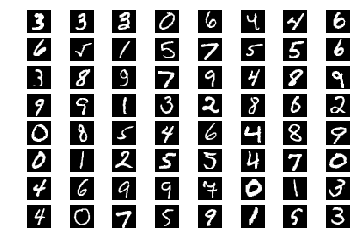

In [11]:
plotter(next(MNISTd)[0:64])

In [23]:
d = next(MNISTd)
d = d.reshape(-1,1,28,28)
# print(d.shape)
vis.images(d[0:45,:,:,:],
          opts=dict(title='Random!', caption='How random.'),)

'window_35ca4b20712fdc'

In [10]:
#pretraining
E = Encoder().cuda()
D = Decoder().cuda()
E = E.double()
D = D.double()
E.apply(wt_init)
D.apply(wt_init)
print(E)
print(D)

Encoder (
  (L1): Linear (784 -> 512)
  (Ou): Linear (512 -> 100)
  (L3): Linear (100 -> 100)
  (L4): Linear (100 -> 100)
)
Decoder (
  (L1): Linear (100 -> 512)
  (Ou): Linear (512 -> 784)
)


In [11]:
list(E.parameters())+ list(D.parameters())

[Parameter containing:
 -1.9640e-02 -2.3295e-02 -2.6851e-03  ...  -3.5350e-02  5.2130e-03 -2.7663e-02
  1.2052e-02  1.1397e-02 -1.0613e-02  ...   3.2838e-02 -1.5700e-02 -8.2672e-03
  2.9986e-02 -2.0878e-02 -2.7616e-02  ...  -1.3098e-02 -2.2771e-02  2.4104e-02
                 ...                   ⋱                   ...                
  3.7597e-03 -6.4100e-03 -1.8698e-02  ...  -3.9118e-03  2.3403e-02  1.4560e-02
 -9.4073e-03 -5.8338e-03 -1.7089e-02  ...  -3.2162e-02  1.0792e-02 -5.0744e-03
 -1.2779e-02  1.4320e-02 -1.8676e-02  ...   1.9282e-02 -2.3061e-02 -2.6745e-02
 [torch.cuda.DoubleTensor of size 512x784 (GPU 0)], Parameter containing:
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  

In [12]:
optim = tchoptim.Adam(list(E.parameters())+ list(D.parameters()), lr=1e-3)

In [13]:
def sample_z(mu, sig):
    e = Variable(tch.randn(BATCHSZ, e_out_dim).cuda().double())
    r = mu + (e*tch.exp(sig/2))
    return r
    

In [16]:
n_epoch = 100
c
n_iter = 100

randomly chosen 64 reconstruted samples after epoch: 0, itr: 0


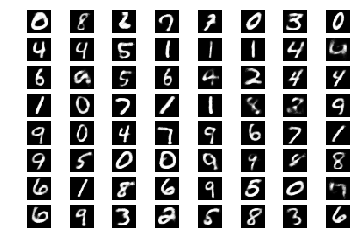

====> Epoch: 0 Average loss: 0.0965
########### generating samples after epoch 0 ###########


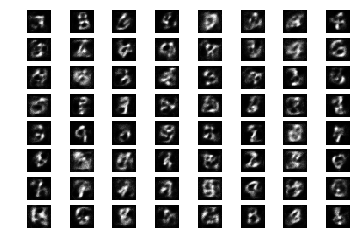

randomly chosen 64 reconstruted samples after epoch: 1, itr: 0


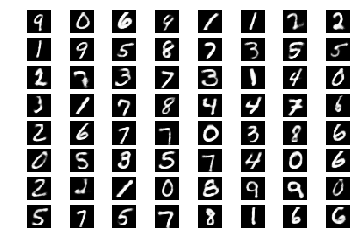

====> Epoch: 1 Average loss: 0.0950
########### generating samples after epoch 1 ###########


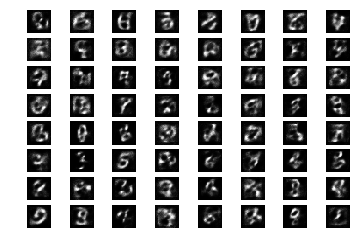

randomly chosen 64 reconstruted samples after epoch: 2, itr: 0


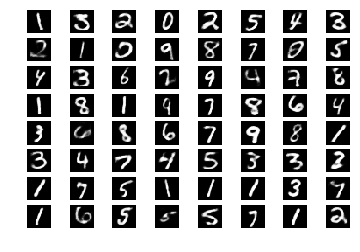

====> Epoch: 2 Average loss: 0.0934
########### generating samples after epoch 2 ###########


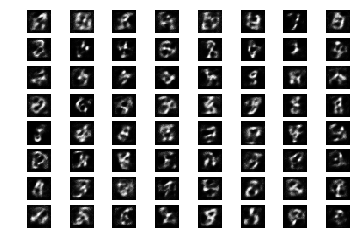

randomly chosen 64 reconstruted samples after epoch: 3, itr: 0


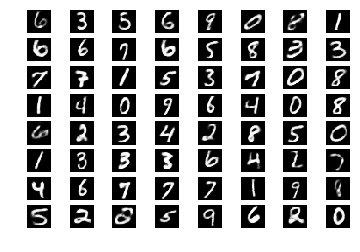

====> Epoch: 3 Average loss: 0.0923
########### generating samples after epoch 3 ###########


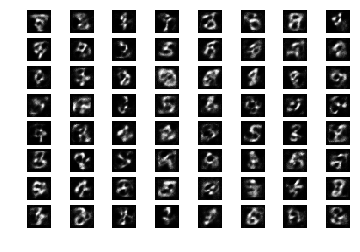

randomly chosen 64 reconstruted samples after epoch: 4, itr: 0


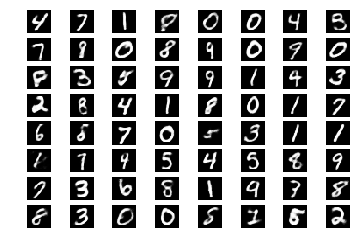

====> Epoch: 4 Average loss: 0.0909
########### generating samples after epoch 4 ###########


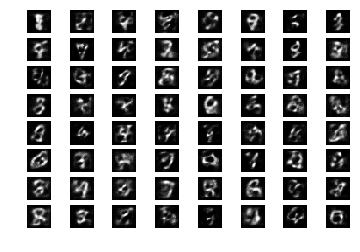

randomly chosen 64 reconstruted samples after epoch: 5, itr: 0


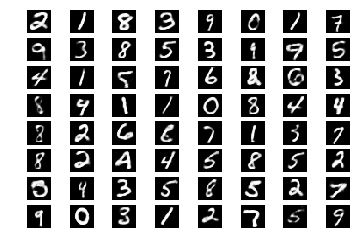

====> Epoch: 5 Average loss: 0.0900
########### generating samples after epoch 5 ###########


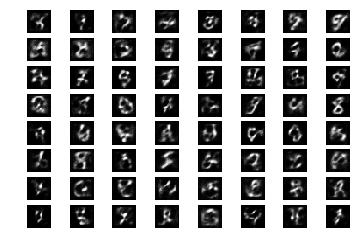

randomly chosen 64 reconstruted samples after epoch: 6, itr: 0


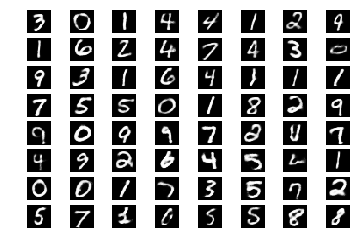

====> Epoch: 6 Average loss: 0.0888
########### generating samples after epoch 6 ###########


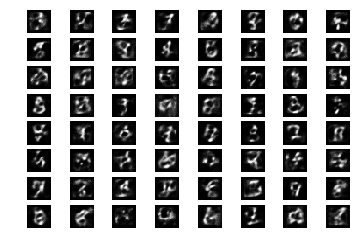

randomly chosen 64 reconstruted samples after epoch: 7, itr: 0


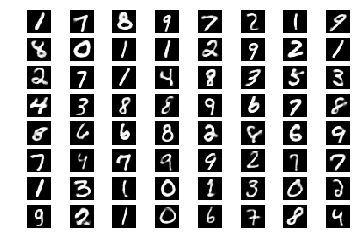

====> Epoch: 7 Average loss: 0.0888
########### generating samples after epoch 7 ###########


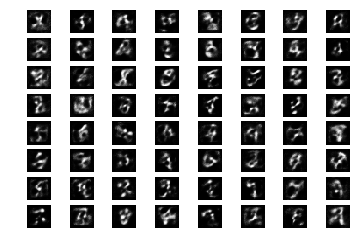

randomly chosen 64 reconstruted samples after epoch: 8, itr: 0


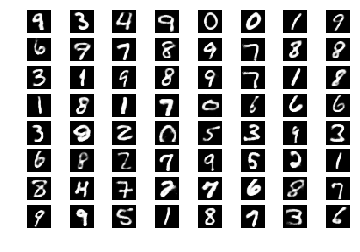

====> Epoch: 8 Average loss: 0.0875
########### generating samples after epoch 8 ###########


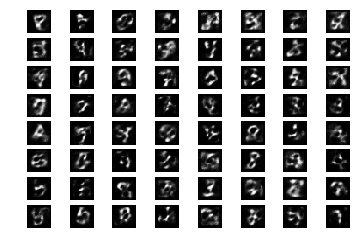

randomly chosen 64 reconstruted samples after epoch: 9, itr: 0


KeyboardInterrupt: 

In [18]:
#training
for eph in range(n_epoch):
    training_loss = 0
    for itr in range(n_iter):
        #print('dbg1')
        X = next(MNISTd)
        X = Variable(tch.from_numpy(X).cuda())
        #through the encoder
        E.zero_grad()
        #print('X shape: {}'.format(X.size()))
        z_mu, z_log_sig = E(X)
        #print('z_mu shape, z_log_sig shape: {}, {}'.format(z_mu.size(), z_log_sig.size()))
        z = sample_z(z_mu, z_log_sig)
        #print('z shape: {}'.format(z.size()))
        #through the decoder
        z = z.cuda()
        D.zero_grad()
        d_out = D(z)
        #loss
        recon_loss = F.binary_cross_entropy(d_out, X)
        KL_div = tch.mean(0.5 * tch.sum(tch.exp(z_log_sig) + z_mu**2 - 1. - z_log_sig, 1))
        KL_div /= BATCHSZ*28*28 # <- learnt a lesson, constansdo matter, kind of like units
        loss = recon_loss + KL_div
        training_loss += loss

        loss.backward()
        optim.step()

        #print results sometimes
        if itr%100 == 0:
            print('randomly chosen 64 reconstruted samples after epoch: {}, itr: {}'.format(eph,itr))
            d = d_out.data.cpu().numpy()
            d = d.reshape(-1,1,28,28)
            d1 = list(d)
            d1 = random.sample(d1, 64)
            d = np.array(d1)
            plotter(d)
    print('====> Epoch: {} Average loss: {:.4f}'.format(eph, training_loss.data.cpu().numpy()[0]/n_iter))
    #generation after this epoch
    print('########### generating samples after epoch {} ###########'.format(eph))
    z_test = tch.randn(n_generated_samples,d_inp_dim)
    z_test = Variable(z_test.view(-1, d_inp_dim).double().cuda())
    #print('ztest shape: {}'.format(z_test.size()))
    y = D(z_test)
    #print('y size: {}'.format(y.size()))
    y = y.data.cpu().numpy().reshape(-1,1,28,28)
    y1 = list(y)
    y1 = random.sample(y1, 64)
    y = np.array(y1)
    plotter(y)
    #to save the model after this epoch (path w.r.t to server)
    tch.save(E.state_dict(), './models/E_epoch{}.pth'.format(eph))
    tch.save(D.state_dict(), './models/D_epoch{}.pth'.format(eph))
    